# Market Mix Modelling Tango

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Load data:
with pd.ExcelFile("../data/raw/Data AA Graph.xlsx") as xlsx:
    omset_df = pd.read_excel(xlsx, "Omset")
    aa_graph_df = pd.read_excel(xlsx, "Data")

# Data Preprocessing

In [2]:
from itertools import product

# Constant 
START_DATE = '2015-01-01'
END_DATE = '2024-03-01'

# Preprocess Omset
def preprocess_omset(df):
    # 1. Create `Periode` column (%Y-%m-%d)
    df['Periode'] = pd.to_datetime(df['Thn'].astype(str) + '-' + df['Bln'].astype(str) + '-01')
    df = df.drop(columns=['Thn', 'Bln'])
    df['KP'] = df['KP'].str.upper()

    # 2. Groupby sum aggregation by `Periode` and `KP`
    df = df.groupby(by=['Periode', 'KP']).agg({'QtyKrt': 'sum', 'Rp': 'sum', 'EC': 'sum'}).reset_index()

    # 3. Filter to only use data until 01-04-2024
    df = df[df['Periode']<=END_DATE]

    # 4. Add zeros for missing values between '2015-01-01' and '2024-03-01'
    kp = df['KP'].unique()
    date_ranges = pd.date_range(start=START_DATE, end=END_DATE, freq='MS')

    complete_date_df = pd.DataFrame(product(date_ranges, kp), columns=['Periode', 'KP'])
    df = complete_date_df.merge(df, how='left', on=['Periode', 'KP']).fillna(0)
    df = df.rename(columns={'QtyKrt': 'Sales'})

    return df

preprocessed_omset_df = preprocess_omset(omset_df.copy())

def preprocess_aa_graph(df):
    # 1. Drop column from `Wilayah`
    df = df.drop(columns=['Wilayah'])

    # 2. Rename column from `Product` to `KP`
    df = df.rename(columns={"Product": "KP"})

    # 3. Normalize string values
    for col in df.select_dtypes('object'):
        df[col] = df[col].str.upper()

    # 4. Change unit of scale from 'Puluhan Jt Rp' TO 'Jt Rupiah'
    def change_unit_scale(row):
        if re.match('.*(PULUHAN JT RP).*', row['Dimensi']):
            row['Value'] = row['Value'] * 10_000_000
            row['Dimensi'] = re.sub('PULUHAN JT RP', 'RP', row['Dimensi'])
        elif re.match('.*(JT RP).*', row['Dimensi']):
            row['Value'] = row['Value'] * 1_000_000
            row['Dimensi'] = re.sub('JT RP', 'RP', row['Dimensi'])
        return row
    df = df.apply(change_unit_scale, axis=1)

    # 5. Change inconsistensies of string in `Dimensi`
    df['Dimensi'] = df['Dimensi'].replace(to_replace=r'YG', value='YANG', regex=True)
    
    # 6. Filter to only use data until 01-03-2024
    df = df[df['Periode']<=END_DATE]
    return df

preprocessed_aa_graph_df = preprocess_aa_graph(aa_graph_df.copy())

In [3]:
def get_data_by_kp(kp, omset_columns, aa_graph_columns):
    subset_omset_df = preprocessed_omset_df[preprocessed_omset_df['KP']==kp]
    subset_omset_df = subset_omset_df[omset_columns]
    subset_aa_graph_df= preprocessed_aa_graph_df[aa_graph_columns]
    df_with_exog = subset_omset_df.merge(subset_aa_graph_df, on=['KP', 'Periode'])
    df_with_exog = df_with_exog.pivot(index=['KP', 'Periode', 'Sales'], columns='Dimensi', values='Value').fillna(0).reset_index()
    df_with_exog = df_with_exog.rename_axis(None, axis=1)
    return df_with_exog

# Market Mix Modelling Tango

In [4]:
kp = 'TANGO WAFER'
omset_columns = ['Periode', 'KP', 'Sales']
aa_graph_columns = ['Periode', 'KP', 'Dimensi', 'Value']
exog_columns = ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'TRADE PROMO (RP)', 'CONSUMER PROMO (RP)']

# Data for statsforecast modelling
tango_df = get_data_by_kp(kp, omset_columns, aa_graph_columns)
tango_df = tango_df[['Periode', 'KP', 'Sales']+exog_columns]

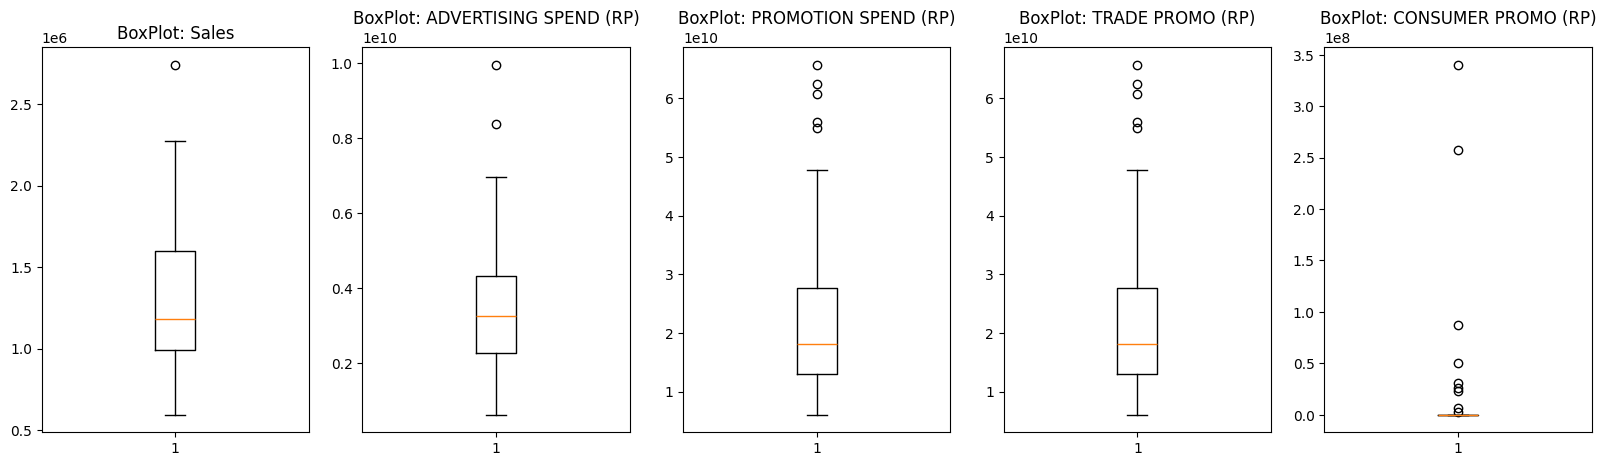

In [5]:
# Identify outliers
fig, ax = plt.subplots(ncols=len(['Sales']+exog_columns), figsize=(20, 5))
for idx, col in enumerate(['Sales']+exog_columns):
    ax[idx].boxplot(tango_df[col])
    ax[idx].set_title("BoxPlot: {}".format(col))
plt.show()

# Exploratory Data Analysis

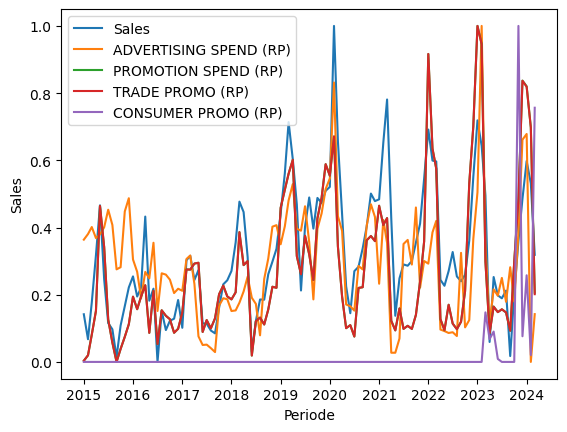

In [6]:
from sklearn.preprocessing import MinMaxScaler
tango_df_scaled = tango_df.copy()
scaler = MinMaxScaler()
tango_df_scaled[['Sales']+exog_columns] = scaler.fit_transform(tango_df_scaled[['Sales']+exog_columns]) 
sns.lineplot(data=tango_df_scaled, x='Periode', y='Sales', label='Sales')
sns.lineplot(data=tango_df_scaled, x='Periode', y='ADVERTISING SPEND (RP)', label='ADVERTISING SPEND (RP)')
sns.lineplot(data=tango_df_scaled, x='Periode', y='PROMOTION SPEND (RP)', label='PROMOTION SPEND (RP)')
sns.lineplot(data=tango_df_scaled, x='Periode', y='TRADE PROMO (RP)', label='TRADE PROMO (RP)')
sns.lineplot(data=tango_df_scaled, x='Periode', y='CONSUMER PROMO (RP)', label='CONSUMER PROMO (RP)')
plt.legend()

## Plot Linear Regression Line

C:\Users\923006079\AppData\Local\Temp\ipykernel_2316\739362948.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\923006079\AppData\Local\Temp\ipykernel_2316\739362948.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\923006079\AppData\Local\Temp\ipykernel_2316\739362948.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


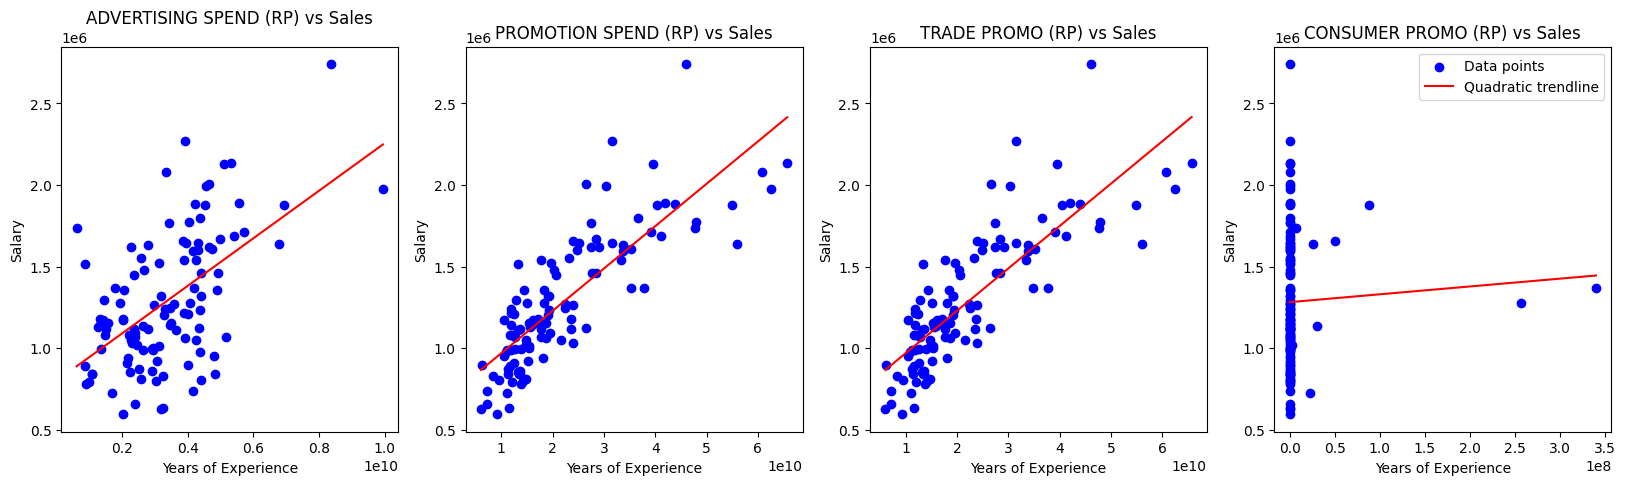

In [7]:
from sklearn.preprocessing import StandardScaler
fig, ax = plt.subplots(ncols=len(exog_columns), figsize=(20, 5))

for idx, col in enumerate(exog_columns):
    # Step 1: Generate some sample data
    x = tango_df[col].to_numpy()
    y = tango_df['Sales'].to_numpy()

    # Step 1: Normalize the data
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    x_normalized = scaler_x.fit_transform(x.reshape(-1, 1)).flatten()
    y_normalized = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Step 2: Fit a quadratic polynomial to the normalized data
    coefficients = np.polyfit(x_normalized, y_normalized, 1)
    quadratic_trendline = np.poly1d(coefficients)

    # Step 3: Generate y values for the trendline
    x_sorted = np.sort(x_normalized)
    y_trend = quadratic_trendline(x_sorted)

    # Step 4: Inverse transform the trendline values to original scale
    x_sorted_original = scaler_x.inverse_transform(x_sorted.reshape(-1, 1)).flatten()
    y_trend_original = scaler_y.inverse_transform(y_trend.reshape(-1, 1)).flatten()

    # Step 5: Plot the scatter plot and the quadratic trendline
    ax[idx].scatter(x, y, label='Data points', color='blue')
    ax[idx].plot(x_sorted_original, y_trend_original, color='red', label='Quadratic trendline')
    ax[idx].set_xlabel('Years of Experience')
    ax[idx].set_ylabel('Salary')
    ax[idx].set_title("{} vs Sales".format(col))
    plt.legend()
plt.show()

## Plot Polynomial Linear Regression Line

C:\Users\923006079\AppData\Local\Temp\ipykernel_2316\2320701666.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\923006079\AppData\Local\Temp\ipykernel_2316\2320701666.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\923006079\AppData\Local\Temp\ipykernel_2316\2320701666.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


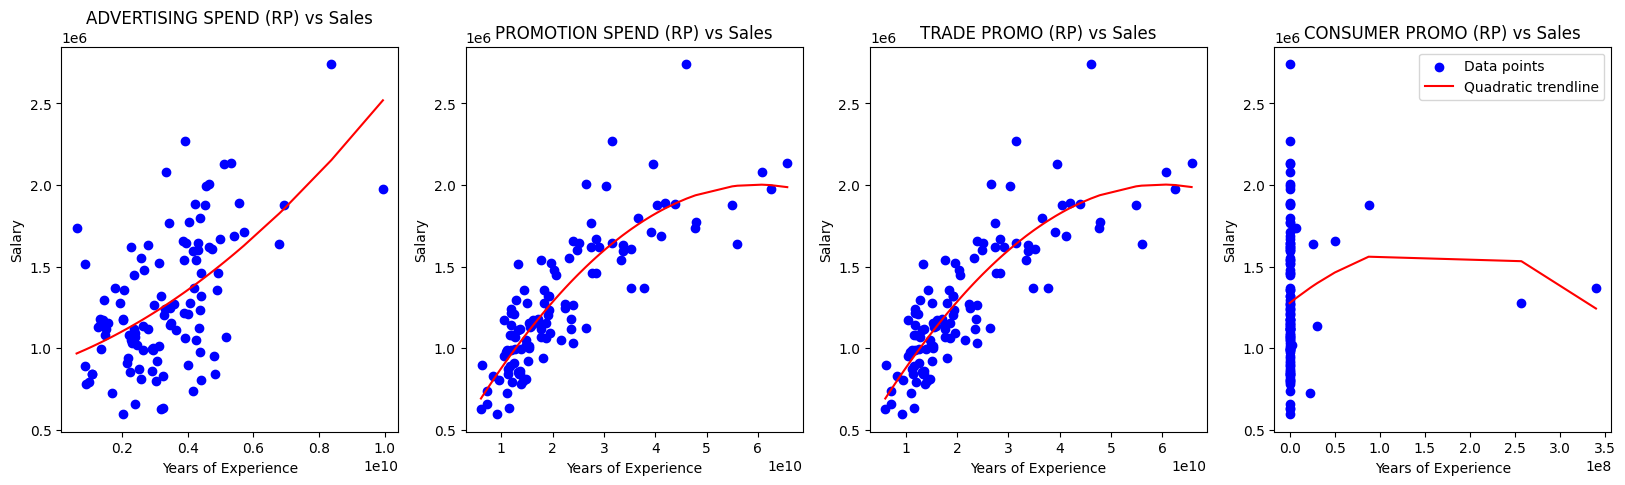

In [8]:
from sklearn.preprocessing import StandardScaler
fig, ax = plt.subplots(ncols=len(exog_columns), figsize=(20, 5))

for idx, col in enumerate(exog_columns):
    # Step 1: Generate some sample data
    x = tango_df[col].to_numpy()
    y = tango_df['Sales'].to_numpy()

    # Step 1: Normalize the data
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    x_normalized = scaler_x.fit_transform(x.reshape(-1, 1)).flatten()
    y_normalized = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Step 2: Fit a quadratic polynomial to the normalized data
    coefficients = np.polyfit(x_normalized, y_normalized, 2)
    quadratic_trendline = np.poly1d(coefficients)

    # Step 3: Generate y values for the trendline
    x_sorted = np.sort(x_normalized)
    y_trend = quadratic_trendline(x_sorted)

    # Step 4: Inverse transform the trendline values to original scale
    x_sorted_original = scaler_x.inverse_transform(x_sorted.reshape(-1, 1)).flatten()
    y_trend_original = scaler_y.inverse_transform(y_trend.reshape(-1, 1)).flatten()

    # Step 5: Plot the scatter plot and the quadratic trendline
    ax[idx].scatter(x, y, label='Data points', color='blue')
    ax[idx].plot(x_sorted_original, y_trend_original, color='red', label='Quadratic trendline')
    ax[idx].set_xlabel('Years of Experience')
    ax[idx].set_ylabel('Salary')
    ax[idx].set_title("{} vs Sales".format(col))
    plt.legend()
plt.show()

## Pearson Correlation

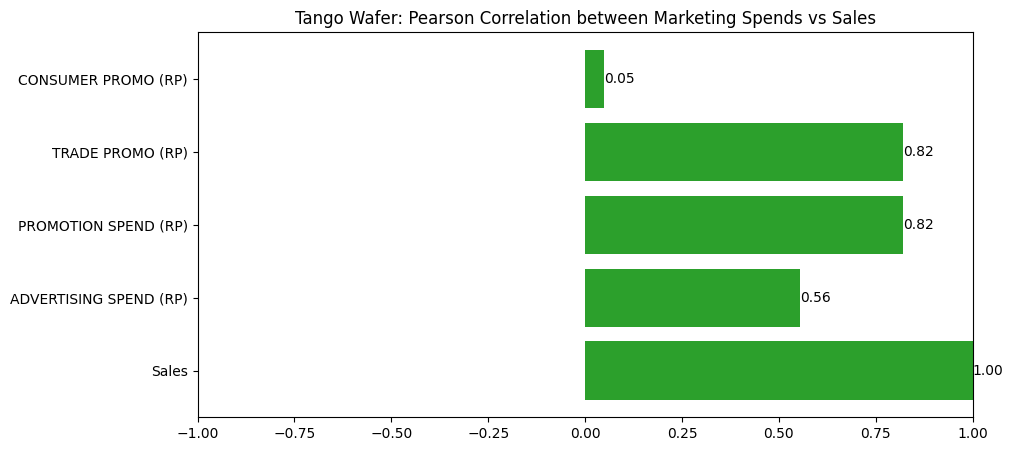

In [9]:
def plot_correlation_coefficient(data, title):
    plt.figure(figsize=(10, 5))
    colors = ['tab:green' if value >= 0 else 'tab:red' for value in data.values]
        # Create the horizontal bar plot
    bars = plt.barh(data.index, data.values, color=colors)
    
    # Add annotations
    for bar in bars:
        width = bar.get_width()
        if width > 0:
            plt.text(width+0.04, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', 
                 ha='center', va='center', color='black', fontsize=10)
        else: 
            plt.text(width-0.04, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', 
                 ha='center', va='center', color='black', fontsize=10)
    plt.title(title)
    plt.xlim([-1, 1])
    plt.show()

plot_correlation_coefficient(tango_df[['Sales']+exog_columns].corr()['Sales'], "Tango Wafer: Pearson Correlation between Marketing Spends vs Sales")
plt.show()

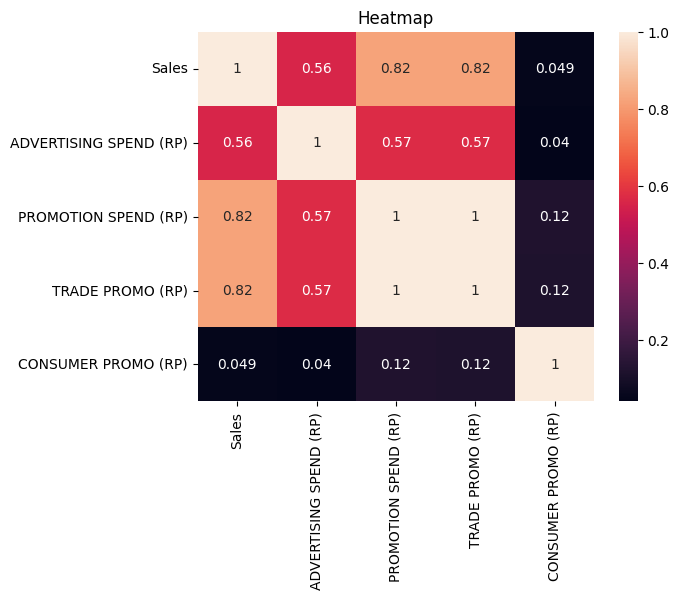

In [10]:
sns.heatmap(tango_df[['Sales']+exog_columns].corr(), annot=True)
plt.title("Heatmap")
plt.show()

# Modelling

In [11]:
from statsforecast import StatsForecast
from datetime import datetime
"""Data Preparation for StatsForecast modelling"""
TRAIN_CUTOFF = datetime(year=2022, month=12, day=1)

kp = 'TANGO WAFER'
omset_columns = ['Periode', 'KP', 'Sales']
aa_graph_columns = ['Periode', 'KP', 'Dimensi', 'Value']
exog_columns = ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'TRADE PROMO (RP)', 'CONSUMER PROMO (RP)']

# Data for statsforecast modelling
tango_df = get_data_by_kp(kp, omset_columns, aa_graph_columns)
tango_df = tango_df[['Periode', 'KP', 'Sales']+exog_columns]

# Split Data
train_df = tango_df[tango_df['Periode']<=TRAIN_CUTOFF].reset_index(drop=True)
test_df = tango_df[tango_df['Periode']>TRAIN_CUTOFF].reset_index(drop=True)

c:\Users\923006079\AppData\Local\anaconda3\envs\revenue-forecasting\lib\site-packages\statsforecast\core.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Model Baseline

In [22]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Features and targets
features = ['CONSUMER PROMO (RP)', 'ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'TRADE PROMO (RP)']
target = 'Sales'

# Split into training features and targets
X_train, X_test, y_train, y_test = train_df[features], test_df[features], train_df[target], test_df[target]

# Standardized features
scaler = StandardScaler()
X_train_preprocessed = X_train.copy() 
X_train_preprocessed[features] = np.log1p(X_train_preprocessed)
X_train_preprocessed[features] = scaler.fit_transform(X_train_preprocessed)
X_test_preprocessed = X_test.copy() 
X_test_preprocessed[features] = np.log1p(X_test_preprocessed)
X_test_preprocessed[features] = scaler.transform(X_test_preprocessed)

# Prepare Model
lr = LinearRegression()

# Train
lr.fit(X_train_preprocessed, y_train)

# Evaluation
print("Train MAPE: {}".format(np.sqrt(mean_absolute_percentage_error(y_train, lr.predict(X_train_preprocessed)))))
print("Test MAPE: {}".format(np.sqrt(mean_absolute_percentage_error(y_test, lr.predict(X_test_preprocessed)))))
print("Train R2: {}".format(r2_score(y_train, lr.predict(X_train_preprocessed))))
print("Test R2: {}".format(r2_score(y_test, lr.predict(X_test_preprocessed))))

Train MAPE: 0.3551207343409424
Test MAPE: 0.4065207080996916
Train R2: 0.7278682221623348
Test R2: 0.7289807732291496


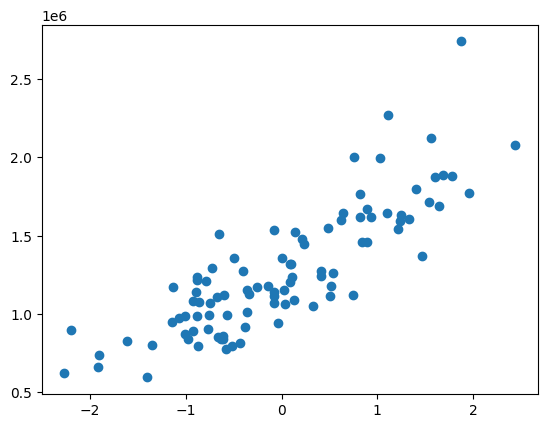

In [23]:
# plt.scatter(X_train_preprocessed, lr.predict(X_train_preprocessed))
plt.scatter(X_train_preprocessed.iloc[:, 3], y_train)

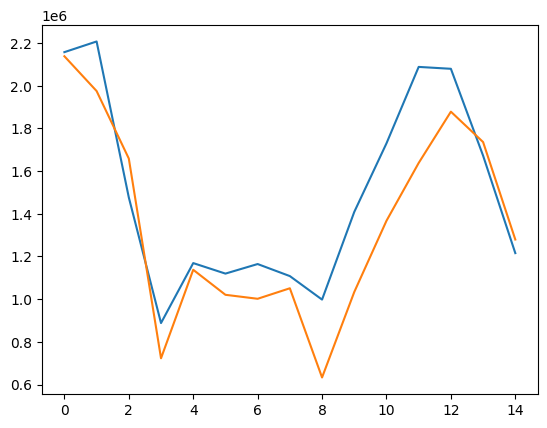

In [20]:
plt.plot(lr.predict(X_test_preprocessed))
plt.plot(y_test)

## Market Mix Modelling

In [4]:
!pip install jax

^C


     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.8 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.8 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.8 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.8 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.8 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.8 kB ? eta -:--:--
     -------------------------------------- 60.8/60.8 kB 161.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ------- -------------------------------- 0.4/2.0 MB 11.2 MB/s eta 0:00:01
   ----------------- ---------------------- 0.9/2.0 MB 11.3 MB/s eta 0:00:01
   ------------------------------ --------- 1.5/2.0 MB 12.2 MB/s eta 0:00:01
   ---------------------------------------  2.0/2.0 MB 11.6 MB/s eta 0:00:01
   ------------------------------


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: C:\Users\923006079\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [5]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro
import pandas as pd

ModuleNotFoundError: No module named 'jax'